In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import re

import torch
from torch.utils.data import DataLoader

from dpt.plmodels import InteriorNetDPT
from data.InteriorNetDataset import InteriorNetDataset
from data.metrics import SILog, DepthMetrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device name: {torch.cuda.get_device_name(0) if device != "cpu" else "cpu"}')

device name: Tesla V100-SXM2-32GB


In [3]:
# k8s paths
k8s = True
k8s_repo = r'opt/repo/dynamic-inference'
k8s_pvc = r'christh9-pvc'

# path settings
model_path = 'weights/dpt_hybrid_nyu-2ce69ec7.pt'
dataset_path = 'video_inference_common/resources'
logs_path = 'train-logs'

checkpoint_name = 'version_293'

if k8s:
    model_path = os.path.join(k8s_pvc, 'dpt-hybrid-nyu.pt')
    dataset_path = os.path.join(k8s_repo, dataset_path)
    logs_path = os.path.join(k8s_pvc, logs_path)
    
    checkpoint_dir = os.path.join(logs_path, 'finetune', checkpoint_name, 'checkpoints')
    
    os.chdir('/')

In [4]:
# select a checkpoint path based on the ones available
checkpoint_dir = 'lightning_logs/version_4/checkpoints'
ckpts = os.listdir(checkpoint_dir)
sorted(ckpts, key=lambda x: int(re.findall(r'\d+', x)[0]))

['epoch=1-step=39999.ckpt']

In [5]:
chosen_ckpt = ckpts[-1]
checkpoint_path = os.path.join(checkpoint_dir, chosen_ckpt)

In [6]:
model = InteriorNetDPT(batch_size=1, 
                       lr=0, 
                       num_epochs=0, 
                       model_path=checkpoint_path)

model = model.load_from_checkpoint(checkpoint_path)
model.to(device)
model.freeze()

In [7]:
train_dataset = InteriorNetDataset(dataset_path, split='train', 
                                   transform='default')

test_dataset = InteriorNetDataset(dataset_path, split='test',
                                  transform='default')

example_dataset = InteriorNetDataset(dataset_path, split='test',
                                     transform='default', subsample=True)

train_loader = DataLoader(train_dataset, batch_size=1)

test_loader = DataLoader(test_dataset, batch_size=1)

example_loader = DataLoader(example_dataset, batch_size=1)

metrics = DepthMetrics(n_deltas=3)

In [8]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 4 finetune err:
absrel: 0.03236420452594757
mae: 0.0926399752497673
rmse: 0.0926399752497673
lg10: 0.014050975441932678
delta1: 0.9912532567977905
delta2: 0.9961816668510437
delta3: 1.0


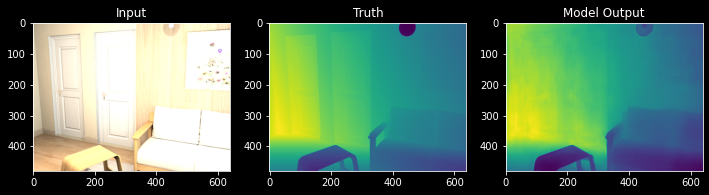

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 9 finetune err:
absrel: 0.04286052659153938
mae: 0.10060526430606842
rmse: 0.10060526430606842
lg10: 0.017720306292176247
delta1: 0.9778906106948853
delta2: 0.9848046898841858
delta3: 0.9995442628860474


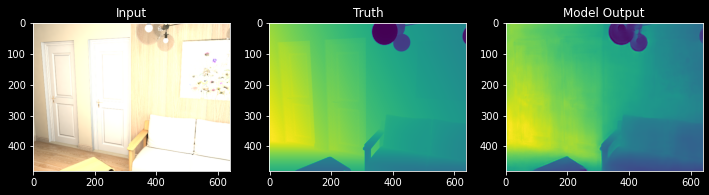

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 14 finetune err:
absrel: 0.0675361156463623
mae: 0.13043279945850372
rmse: 0.13043279945850372
lg10: 0.02727290615439415
delta1: 0.9310156106948853
delta2: 0.9823991060256958
delta3: 0.999010443687439


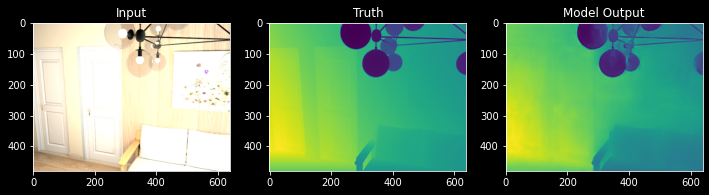

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 19 finetune err:
absrel: 0.09149295091629028
mae: 0.16013531386852264
rmse: 0.16013531386852264
lg10: 0.03665531426668167
delta1: 0.90597003698349
delta2: 0.9795182347297668
delta3: 0.9968163967132568


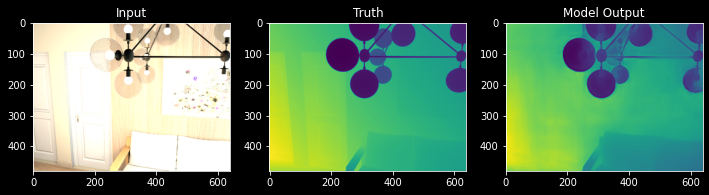

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 24 finetune err:
absrel: 0.09378724545240402
mae: 0.171645849943161
rmse: 0.171645849943161
lg10: 0.03843408077955246
delta1: 0.9013215899467468
delta2: 0.9848730564117432
delta3: 0.9992382526397705


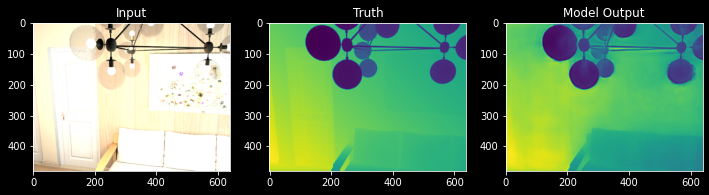

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 29 finetune err:
absrel: 0.10162973403930664
mae: 0.17999418079853058
rmse: 0.17999418079853058
lg10: 0.04079408571124077
delta1: 0.9047786593437195
delta2: 0.9713216423988342
delta3: 0.9989941120147705


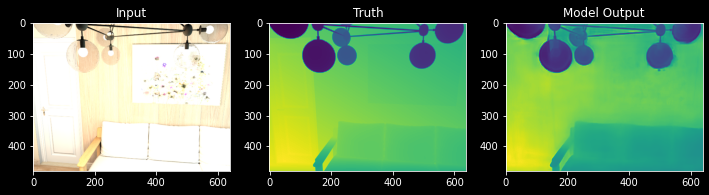

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 34 finetune err:
absrel: 0.11470144987106323
mae: 0.20396669209003448
rmse: 0.20396669209003448
lg10: 0.04536966606974602
delta1: 0.9134472608566284
delta2: 0.9496028423309326
delta3: 0.9941439032554626


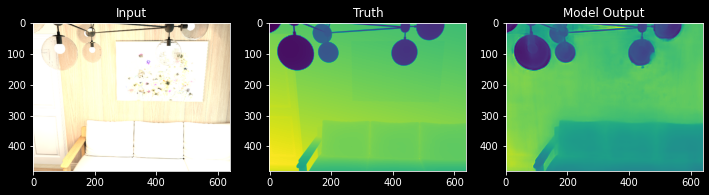

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 39 finetune err:
absrel: 0.09227678179740906
mae: 0.17721503973007202
rmse: 0.17721503973007202
lg10: 0.036286361515522
delta1: 0.9497330784797668
delta2: 0.9696809649467468
delta3: 0.9883984327316284


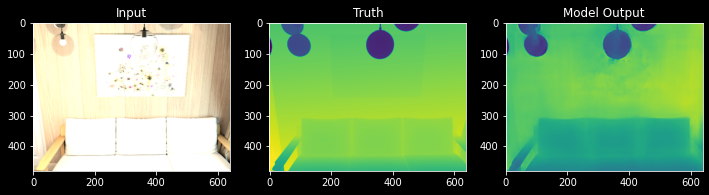

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 44 finetune err:
absrel: 0.09611044079065323
mae: 0.17948275804519653
rmse: 0.17948275804519653
lg10: 0.036825306713581085
delta1: 0.9599056243896484
delta2: 0.9641764163970947
delta3: 0.9768391847610474


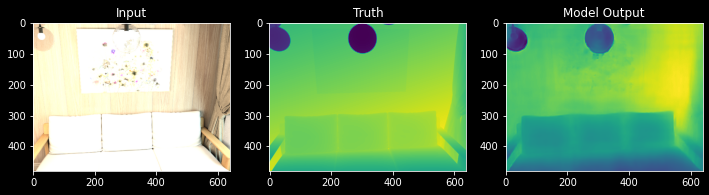

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 49 finetune err:
absrel: 0.09266789257526398
mae: 0.17421412467956543
rmse: 0.17421412467956543
lg10: 0.03501686081290245
delta1: 0.9730729460716248
delta2: 0.9784635305404663
delta3: 0.9786132574081421


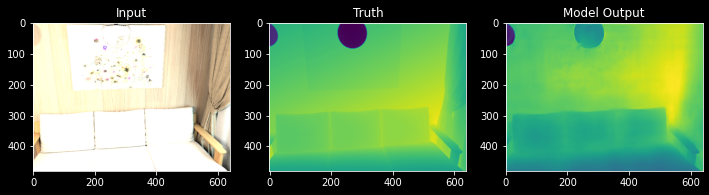

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 54 finetune err:
absrel: 0.08753974735736847
mae: 0.1654387265443802
rmse: 0.1654387265443802
lg10: 0.03304203599691391
delta1: 0.9821842312812805
delta2: 0.983802080154419
delta3: 0.9839680790901184


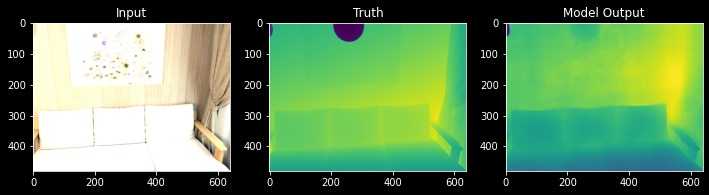

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 59 finetune err:
absrel: 0.0630321130156517
mae: 0.1314297914505005
rmse: 0.1314297914505005
lg10: 0.02533707022666931
delta1: 0.9940755367279053
delta2: 0.9941829442977905
delta3: 0.9942317605018616


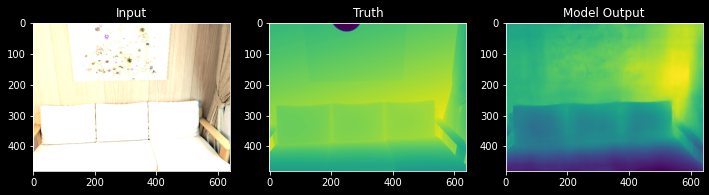

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 64 finetune err:
absrel: 0.048847198486328125
mae: 0.11299508810043335
rmse: 0.11299508810043335
lg10: 0.021422868594527245
delta1: 1.0
delta2: 1.0
delta3: 1.0


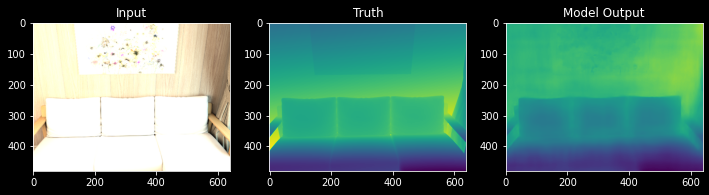

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 69 finetune err:
absrel: 0.05455036833882332
mae: 0.11837159842252731
rmse: 0.11837159842252731
lg10: 0.023258965462446213
delta1: 1.0
delta2: 1.0
delta3: 1.0


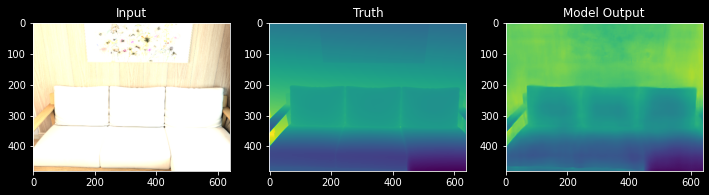

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 74 finetune err:
absrel: 0.05319425091147423
mae: 0.11372364312410355
rmse: 0.11372364312410355
lg10: 0.023071495816111565
delta1: 0.9999414086341858
delta2: 1.0
delta3: 1.0


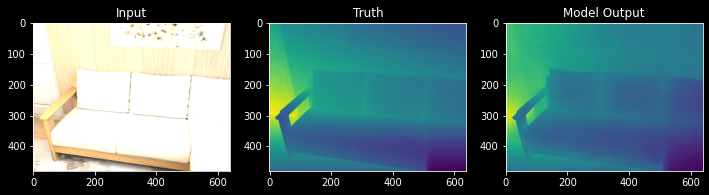

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 79 finetune err:
absrel: 0.0423002727329731
mae: 0.08569211512804031
rmse: 0.08569211512804031
lg10: 0.018448639661073685
delta1: 0.9998144507408142
delta2: 1.0
delta3: 1.0


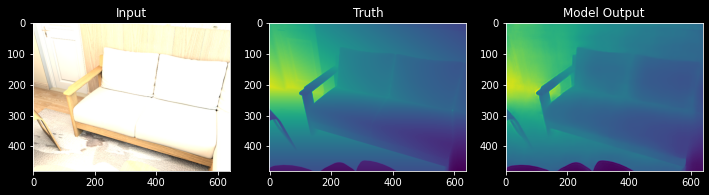

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 84 finetune err:
absrel: 0.05170917138457298
mae: 0.0858510360121727
rmse: 0.0858510360121727
lg10: 0.02310778759419918
delta1: 0.9492252469062805
delta2: 1.0
delta3: 1.0


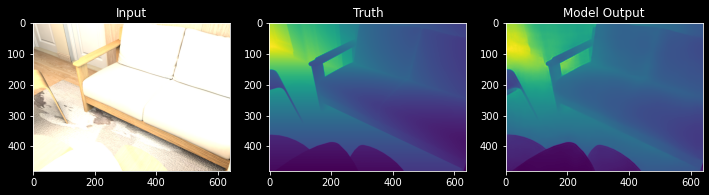

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 89 finetune err:
absrel: 0.04893558472394943
mae: 0.06365194916725159
rmse: 0.06365194916725159
lg10: 0.021868683397769928
delta1: 0.9871321320533752
delta2: 0.9995800852775574
delta3: 1.0


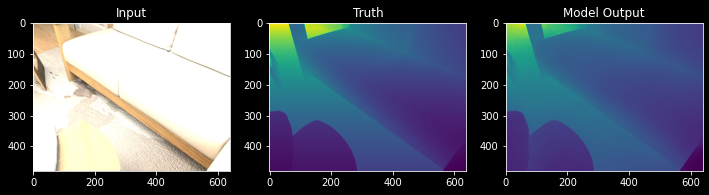

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 94 finetune err:
absrel: 0.06918905675411224
mae: 0.07690661400556564
rmse: 0.07690661400556564
lg10: 0.03036215528845787
delta1: 0.9742024540901184
delta2: 1.0
delta3: 1.0


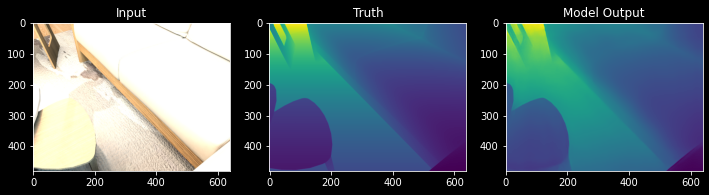

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 99 finetune err:
absrel: 0.0490238219499588
mae: 0.05596514418721199
rmse: 0.05596514418721199
lg10: 0.021577225998044014
delta1: 0.9869335889816284
delta2: 0.9999935030937195
delta3: 1.0


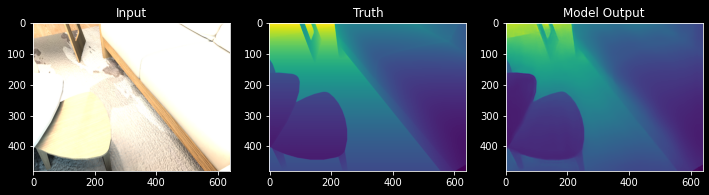

In [9]:
with torch.no_grad():
    for i,batch in enumerate(example_loader):
        if (i+1) % 5 == 0:
            im, depth = batch['image'].to(device), batch['depth'].to(device)
            out = model(im)

            acc = metrics(out, depth, None) # val_
            fig, axs = plt.subplots(1,3, figsize=(12,12))

            print(f'Frame {i} finetune err:')
            acc.pop('s')
            acc.pop('t')
            for name, value in acc.items():
                print(f'{name}: {value}')

            axs[0].imshow(im.squeeze(0).permute([1,2,0]).cpu())
            axs[1].imshow(depth.squeeze(0).cpu())
            axs[2].imshow(out.squeeze(0).cpu())

            axs[0].set_title('Input')
            axs[1].set_title('Truth')
            axs[2].set_title('Model Output')

            plt.show()

In [10]:
from collections import Counter

train_stats = Counter({
    'absrel': 0.,
    'mae': 0.,
    'delta1': 0.,
    'delta2': 0.,
    'delta3': 0.,
    'rmse': 0.,
    'lg10': 0.,
})

i = 0
with torch.no_grad():
    for batch in train_loader:
        im, depth = batch['image'].to(device), batch['depth'].to(device)
        out = model(im)
        
        stats = Counter(metrics(out, depth, None))
        if 's' in stats: del stats['s']
        if 't' in stats: del stats['t']
        
        train_stats += stats
        i += 1
        if i >= 100: break

In [11]:
for stat in train_stats:
    train_stats[stat] /= 100

In [12]:
train_stats

Counter({'absrel': 0.03506964268162847,
         'mae': 0.07776602197438479,
         'delta1': 0.995290395617485,
         'delta2': 0.9997178715467453,
         'delta3': 0.9999844378232956,
         'rmse': 0.07776602197438479,
         'lg10': 0.01544735104776919})